In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

# fix seed
import numpy as np
import random
seed = 0
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


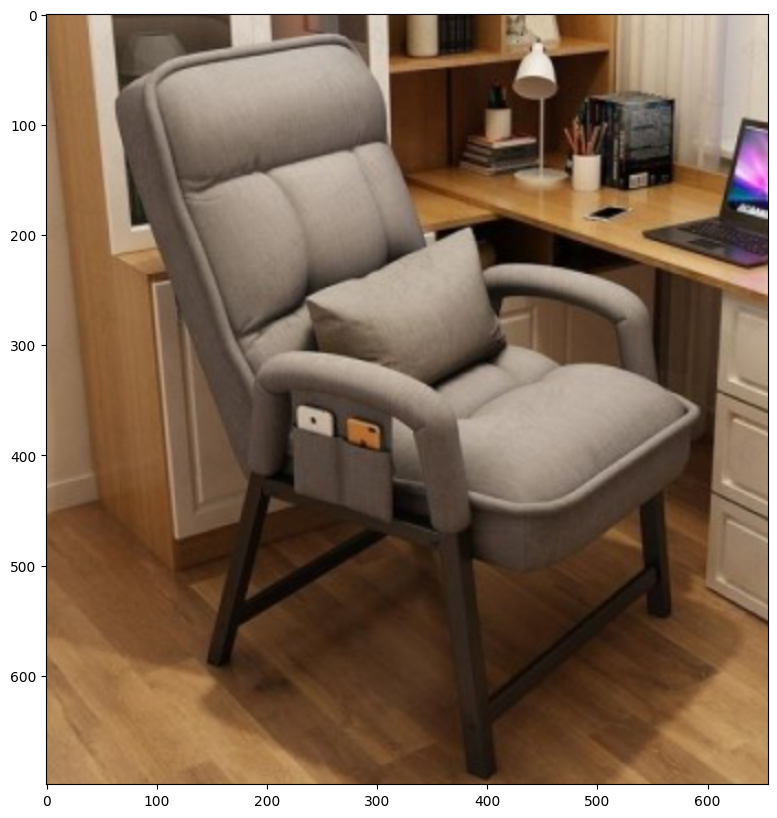

In [7]:
img_name = 'sss_bg_chair'
prompt_name = None
img_path = f'test_img/origin_img/{img_name}.png'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [8]:
import sys
sys.path.append("segment-anything/")        # add segment-anything to PYTHONPATH
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "segment-anything/checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

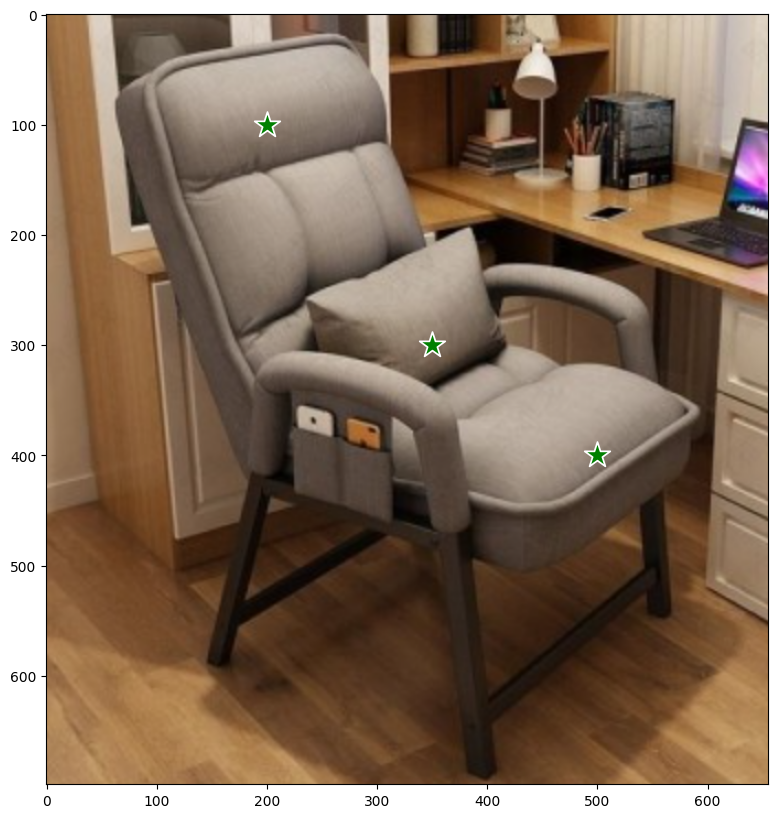

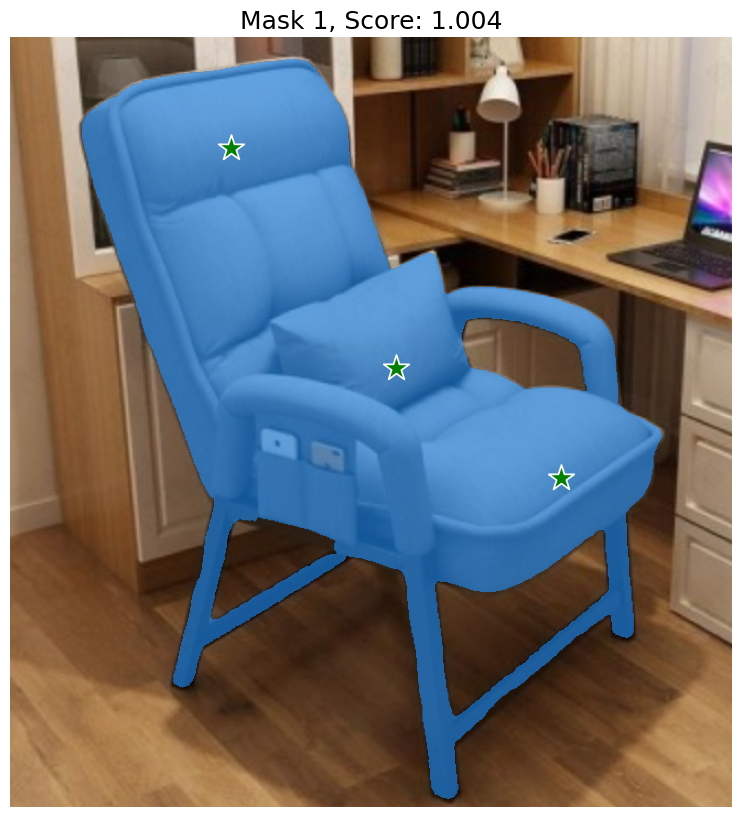

(699, 655, 1)

In [9]:
# vis object mask
# the dog
input_point = np.array([[350, 300], [500, 400], [200, 100]])            # [W, H], more points for total mask
input_label = np.array([1, 1, 1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

obj_vis_masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

obj_vis_masks.shape  # (number_of_masks) x H x W
# show mask
for i, (mask, score) in enumerate(zip(obj_vis_masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


obj_vis_masks = obj_vis_masks.transpose(1, 2, 0)  # H x W x 1
obj_vis_masks.shape


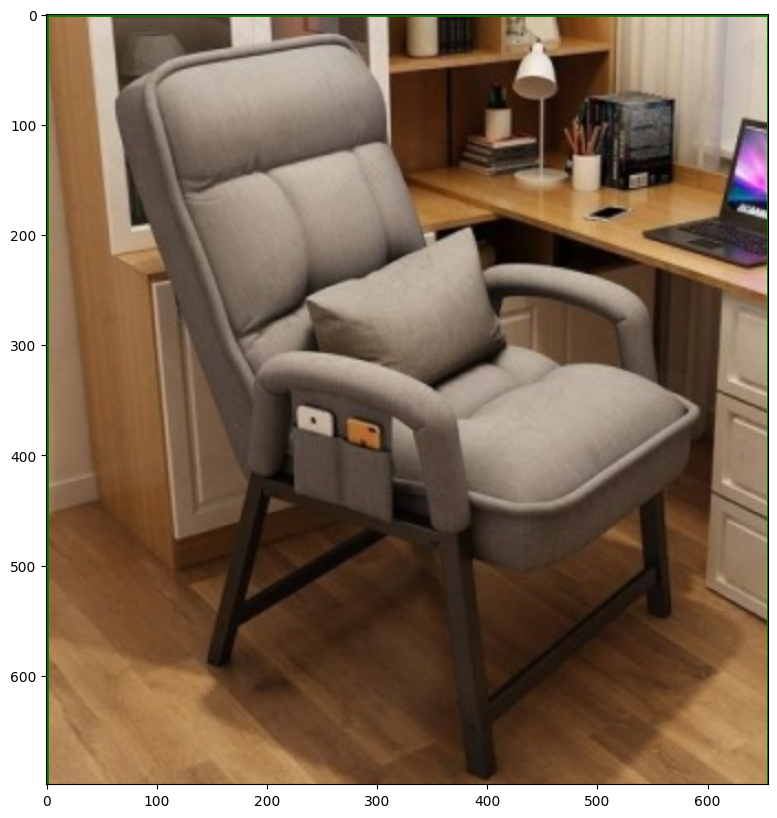

In [10]:
# calculate crop bbox
height, width, _ = obj_vis_masks.shape
vis_masks_idx = np.argwhere(obj_vis_masks == 1)
vis_masks_idx.shape
px = vis_masks_idx[:, 0]
py = vis_masks_idx[:, 1]
xmin, xmax = int(np.min(py)), int(np.max(py))       # W
ymin, ymax = int(np.min(px)), int(np.max(px))       # H
full_bbox_2d = [xmin, ymin, xmax, ymax]
x_center, y_center = (xmin + xmax) // 2, (ymin + ymax) // 2

square_length = max(xmax - xmin, ymax - ymin) + 100
x_square_begin, y_square_begin = max(0, x_center - square_length // 2), max(0, y_center - square_length // 2)
[x_square_end, y_square_end] = [min(width, x_square_begin + square_length), min(height, y_square_begin + square_length)]
crop_bbox = [x_square_begin, y_square_begin, x_square_end, y_square_end]

plt.figure(figsize=(10,10))
plt.imshow(image)
show_box(crop_bbox, plt.gca())
plt.show()

# get vis object image, use PIL
from PIL import Image

img = Image.open(img_path)
img_np = np.array(img)
height, width, _ = img_np.shape

save_vis_img = np.ones((height, width, 3), dtype=np.uint8) * 225
save_vis_img[obj_vis_masks[:, :, 0] == 1] = img_np[obj_vis_masks[:, :, 0] == 1]
save_vis_img = save_vis_img[y_square_begin:y_square_end, x_square_begin:x_square_end, :]            # crop square image
save_vis_img = Image.fromarray(save_vis_img)
# save_vis_img.show()
save_vis_img.save(f'test_img/seg_img/{img_name}_vis.jpg')

In [ ]:
# diffuser mask
# the cat
input_point = np.array([[350, 350]])            # [W, H]
input_label = np.array([1])
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

diffuser_masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

diffuser_masks.shape  # (number_of_masks) x H x W
# # show mask
# for i, (mask, score) in enumerate(zip(diffuser_masks, scores)):
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     show_mask(mask, plt.gca())
#     show_points(input_point, input_label, plt.gca())
#     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
#     plt.axis('off')
#     plt.show()


diffuser_masks = diffuser_masks.transpose(1, 2, 0)  # H x W x 1
diffuser_masks.shape

# save diffuser mask
diffuser_masks = diffuser_masks.astype(np.uint8)
crop_diffuse_mask = diffuser_masks[y_square_begin:y_square_end, x_square_begin:x_square_end, :]            # setting crop, must be square            # setting crop, must be square
crop_diffuse_mask = crop_diffuse_mask[:, :, 0]
save_diffuse_mask = Image.fromarray(crop_diffuse_mask * 255)
# save_diffuse_mask.show()
save_diffuse_mask.save(f'test_img/seg_img/{img_name}_diffuse_mask.jpg')

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image
import numpy as np

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe.to("cuda")

def img_resize(img, size):
    img = img.resize(size, Image.ANTIALIAS)
    return img

In [ ]:
prompt = "a table"
prompt_name = prompt.replace(' ', '_')
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image = Image.open(f'test_img/seg_img/{img_name}_vis.jpg')
image = img_resize(image, (512, 512))
mask_image = Image.open(f'test_img/seg_img/{img_name}_diffuse_mask.jpg')
# mask_image = gray2rgb(np.array(mask_image))
mask_image = img_resize(mask_image, (512, 512))
image = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
# image = pipe(image=image, mask_image=mask_image).images[0]
image.save(f'test_img/inpainting_img/{img_name}_{prompt_name}.jpg')

In [11]:
import torch
import os

sys.path.append("shap-e/")          # add shap-e to PYTHONPATH
from shap_e.diffusion.sample import sample_latents
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config
from shap_e.models.download import load_model, load_config
from shap_e.util.notebooks import create_pan_cameras, decode_latent_images, gif_widget
from shap_e.util.image_util import load_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

xm = load_model('transmitter', device=device, cache_dir='shap-e/shap_e/examples/shap_e_model_cache')
model = load_model('image300M', device=device, cache_dir='shap-e/shap_e/examples/shap_e_model_cache')
diffusion = diffusion_from_config(load_config('diffusion'))

In [12]:
batch_size = 4
guidance_scale = 3.0

# To get the best result, you should remove the background and show only the object of interest to the model.
if prompt_name == None:                     # not use diffuser inpainting
    prompt_name = 'vis'
image = load_image(f"test_img/inpainting_img/{img_name}_{prompt_name}.jpg")
os.makedirs(f'test_img/recon3D/{img_name}_{prompt_name}', exist_ok=True)

latents = sample_latents(
    batch_size=batch_size,
    model=model,
    diffusion=diffusion,
    guidance_scale=guidance_scale,
    model_kwargs=dict(images=[image] * batch_size),
    progress=True,
    clip_denoised=True,
    use_fp16=True,
    use_karras=True,
    karras_steps=64,
    sigma_min=1e-3,
    sigma_max=160,
    s_churn=0,
)

  0%|          | 0/64 [00:00<?, ?it/s]

In [13]:
# Example of saving the latents as meshes.
from shap_e.util.notebooks import decode_latent_mesh
save_mesh_path = os.path.join(f'test_img/recon3D/{img_name}_{prompt_name}', 'mesh')
os.makedirs(save_mesh_path, exist_ok=True)

for i, latent in enumerate(latents):
    t = decode_latent_mesh(xm, latent).tri_mesh()
    with open(os.path.join(save_mesh_path, f'example_mesh_{i}.ply'), 'wb') as f:
        t.write_ply(f)
    with open(os.path.join(save_mesh_path, f'example_mesh_{i}.obj'), 'w') as f:
        t.write_obj(f)

Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size to 0 to use the naive rasterization.Bin size was too small in the coarse rasterization phase. This caused an overflow, meaning output may be incomplete. To solve, try increasing max_faces_per_bin / max_points_per_bin, decreasing bin_size, or setting bin_size 

In [ ]:
render_mode = 'nerf' # you can change this to 'stf' for mesh rendering
size = 128 # this is the size of the renders; higher values take longer to render.

cameras = create_pan_cameras(size, device)
for i, latent in enumerate(latents):
    images = decode_latent_images(xm, latent, cameras, rendering_mode=render_mode)
    # display(gif_widget(images))

save_root_path = os.path.join(f'test_img/recon3D/{img_name}_{prompt_name}', 'renders')
os.makedirs(save_root_path, exist_ok=True)
img_idx = 0
for image in images:
    image.save(os.path.join(save_root_path, f'{img_idx}.png'))
    img_idx += 1
print('save over!')